In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import glob
import os
import random
import urllib
from tensorflow.keras import layers
import tensorflow_io as tfio



#【フォルダ内のjpgファイルを一覧表示】
data_folder = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST")

all_image_paths = list(data_folder.glob('**/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
#print(image_count)

#フォルダ内のjpgファイルのテンソルへのデコードの関数化
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [128, 128])
  image = tfio.experimental.color.rgb_to_grayscale(image) #グレースケール変換
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)



#【ラベルの読み込み】　ラベルは一つずつなのか？同時に二つは無理なのか？　→　まずは一つずつ処理する
label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")
df1 = pd.read_csv(label_path, encoding= "utf-8")

#複数のインデックスを指定
df2 = df1.set_index(['axis', 'Model', 'FaceAngle'])
#display(df2.head(7)) #先頭7行を表示
#print(df2.columns)

#print(all_image_paths)
#print(type(all_image_paths))
#all_image_paths.sort() #パスをソート
#print(all_image_paths[:10])



#【画像のパスの中から、Modelと感情とFaceAngleを抽出する】
#print(type(all_image_paths[0]))
#print(len(all_image_paths))

all_image_paths_Model = []
all_image_paths_info = []
path_base = 'face_AIST'
path_base2 = 'jpg'

for i in range(len(all_image_paths)):
    idx = all_image_paths[i].find(path_base)
    idx2 = all_image_paths[i].find(path_base2)
    all_image_paths_Model.append(all_image_paths[i][idx+10:idx+13])
    all_image_paths_info.append(all_image_paths[i][idx+18:idx2-1])
del i,idx,idx2
#print(all_image_paths_Model[:10])
#print(all_image_paths_info[:10])

all_image_paths_FaceAngle = []
all_image_paths_Emotion = []
path_base = '_'

for i in range(len(all_image_paths)):
    idx = all_image_paths_info[i].find(path_base)
    all_image_paths_Emotion.append(all_image_paths_info[i][:idx])
    all_image_paths_FaceAngle.append(all_image_paths_info[i][idx+1:])
del i,idx

#リスト内の0をfrontに置換
#all_image_paths_FaceAngle = [s.replace('0', 'front') for s in all_image_paths_FaceAngle]
all_image_paths_FaceAngle = ['front' if s=='0' else s for s in all_image_paths_FaceAngle]

#print(all_image_paths_Model[:10])
#print(all_image_paths_Emotion[:10])
#print(all_image_paths_FaceAngle[:10])



#感情のタグをリストとして抽出(不要コード)
Emotag = df2.columns
#print(Emotag)
#【データフレームdf3の項目名を変更】
df3 = df2.rename(index = str.lower)
df3.rename(columns = {'Anger_cl':'angcl', 'Anger_op':'angop', 'Disgust_cl':'discl', \
    'Disgust_op':'disop', 'Excitement':'exc', 'Fear':'fea', 'Happiness':'hap', \
        'Neutral':'neu', 'Relaxation':'rel', 'Sadness':'sad', 'Sleepiness':'sle', \
            'Surprise':'sur'}, inplace = True) 
display(df3.head(7))



#複数インデックスのデータフレーム内の要素へのアクセスのテスト(不要コード)
#print(df2.loc[('Valence','f01', 'Front'),'Anger_cl'])
#【データフレームdf3から、各画像のラベルを抽出してリストに格納】
paths_Valence = []
paths_Arousal = []
for i in range(len(all_image_paths)):
    paths_Valence.append(df3.loc[('valence',all_image_paths_Model[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
    paths_Arousal.append(df3.loc[('arousal',all_image_paths_Model[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
del i
print(paths_Valence[:10])
print(paths_Arousal[:10])
#このように、教師データとラベルをそれぞれ順序一致させてリストに入れれば、データセットが出来る


#データセットはadarray型にする
#おそらくもっと良い読み込み方あるけど、いったんこのやり方で。
images = []
for i in range(len(all_image_paths)):
   images.append(load_and_preprocess_image(all_image_paths[i]))
Ids_raw = np.array(images)  #画像データセット
print(Ids_raw.shape)

LdsV_raw = np.array(paths_Valence)  #Valenceラベルデータセット
LdsA_raw = np.array(paths_Arousal)  #Arousalラベルデータセット


#訓練データとテストデータに分割（検証用データはモデル内で定義）
Ids_train, Ids_test = np.split(Ids_raw,[400],0)
LdsV_train, LdsV_test = np.split(LdsV_raw,[400],0)
LdsA_train, LdsA_test = np.split(LdsA_raw,[400],0)


#モデルの構築
def build_model():
  model = keras.Sequential([
    layers.Flatten(input_shape=(128, 128)),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

#回ってるか試してみた
example_batch = Ids_train[:10]
example_result = model.predict(example_batch)
example_result


#モデルの訓練
#エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 300

# patience は改善が見られるかを監視するエポック数を表すパラメーター
#これ入れるとうまく計算できなかったので、一旦このコールバックは付けない
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Valenceの訓練
history_V = model.fit(
  Ids_train, LdsV_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])
  #callbacks=[early_stop, PrintDot()])

#Arousalの訓練
history_A = model.fit(
  Ids_train, LdsA_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])
  #callbacks=[early_stop, PrintDot()])

angcl     angop     discl     disop       exc  \
axis    Model FaceAngle                                                     
valence f01   right90    3.025641  2.974359  2.743590  2.794872  6.615385   
              right45    2.487179  2.435897  2.743590  2.333333  7.974359   
              front      2.435897  2.487179  2.641026  2.230769  7.923077   
              left45     2.153846  2.666667  2.692308  2.179487  7.897436   
              left90     2.615385  2.307692  2.743590  2.333333  7.794872   
        f02   right90    3.205128  2.769231  2.410256  2.384615  6.948718   
              right45    3.205128  2.743590  2.666667  2.282051  7.692308   

                              fea       hap       neu       rel       sad  \
axis    Model FaceAngle                                                     
valence f01   right90    3.743590  6.589744  5.076923  6.564103  3.230769   
              right45    2.666667  7.743590  4.923077  7.179487  3.256410   
              front      2.615385  7.307692  4.846154  6.846154  2.846154   
              left45     2.589744  7.333333  4.743590  6.846154  2.743590   
              left90     2.641026  7.205128  4.717949  7.076923  3.025641   
        f02   right90    3.435897  7.615385  6.179487  7.076923  3.128205   
              right45    3.076923  7.692308  5.692308  7.179487  3.307692   

                              sle       sur  
axis    Model FaceAngle                      
valence f01   right90    4.692308  4.794872  
              right45    5.000000  5.589744  
              front      5.179487  5.641026  
              left45     5.025641  5.589744  
              left90     5.153846  4.820513  
        f02   right90    5.461538  4.743590  
              right45    5.512821  4.794872

[2.256410256, 2.846153846, 6.487179487, 7.871794872, 4.897435897, 7.487179487, 4.846153846, 3.256410256, 2.743589744, 7.307692308]
[6.051282051, 6.256410256, 4.846153846, 5.435897436, 4.948717949, 5.025641026, 4.743589744, 7.615384615, 5.487179487, 3.666666667]
(480, 128, 128, 1)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               2097280   
_________________________________________________________________
dense_31 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 2,101,441
Trainable params: 2,101,441
Non-trainable params: 0
__________________________

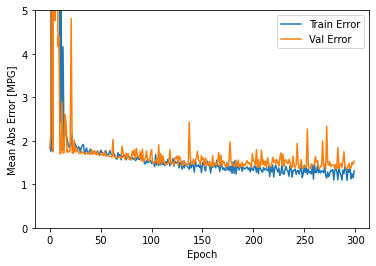

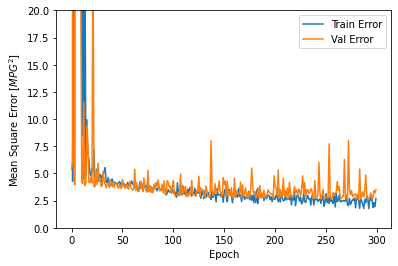

In [24]:
#モデルの訓練の様子の可視化_Valence
def plot_history(history_V):
  hist = pd.DataFrame(history_V.history)
  hist['epoch'] = history_V.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_V)

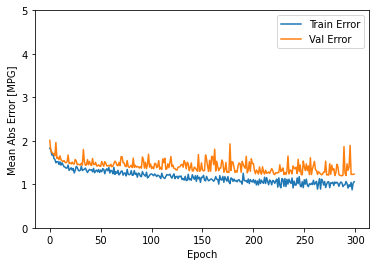

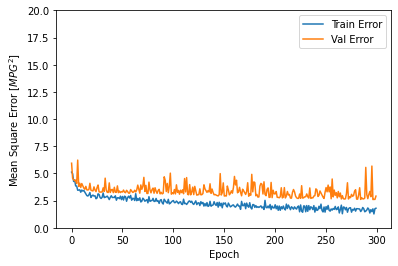

In [25]:
#モデルの訓練の様子の可視化_Arousal
def plot_history(history_A):
  hist = pd.DataFrame(history_A.history)
  hist['epoch'] = history_A.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_A)

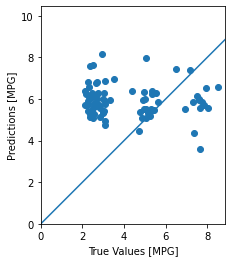

In [35]:
#テスト用ラベルで確認
#Valenceの推定

test_predictions_V = model.predict(Ids_test).flatten()
plt.scatter(LdsV_test, test_predictions_V)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


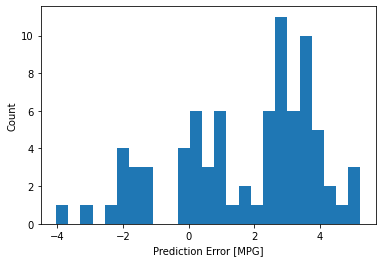

In [36]:
#Valenceの誤差分布
error_V = test_predictions_V - LdsV_test
plt.hist(error_V, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

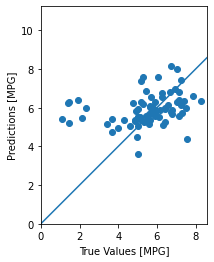

In [29]:
#テスト用ラベルで確認
#Arousalの推定
test_predictions_A = model.predict(Ids_test).flatten()
plt.scatter(LdsA_test, test_predictions_A)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

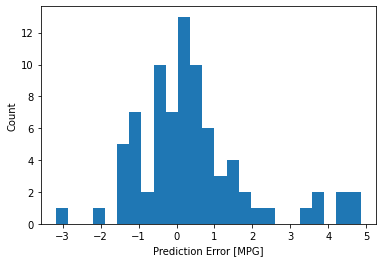

In [37]:
#Valenceの誤差分布
error_A = test_predictions_A - LdsA_test
plt.hist(error_A, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")